In [77]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

**Reading in the data from fer2013.csv**

**The dataset is taken from `https://www.kaggle.com/gauravsharma99/facial-emotion-recognition/data`**

In [31]:
df = pd.read_csv("./fer2013.csv")

**Checking the head of the dataframe**

In [32]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Let's see the distribution of the emotion classes over the data**

In [33]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

**It doesn't make much sence, lets add one more coloums with the named labels**

In [34]:
emotion_labels = {0: "angry", 1: "disgust", 2: "fear", 3: "happiness", 4: "sadness", 5: "surprise", 6: "neutral"}

**After creating the emotion labels, lets map them with the `emotion` coloumn of the dataframe**

In [35]:
df["em"] = df["emotion"].map(emotion_labels)

**Now let's check the distribution again...**

In [36]:
df["em"].value_counts()

happiness    8989
neutral      6198
sadness      6077
fear         5121
angry        4953
surprise     4002
disgust       547
Name: em, dtype: int64

**Woooo ! this makes sense now.**

**But is seems like the data is uneven and unbalanced.**

**Let's keep the following calasses:**
* **Happiness**
* **Sadness**
* **Neutral**

**First, let's create another dataframe to avoide messing with the original dataframe**

In [37]:
training_dataframe = df

In [38]:
required_emotions = [3, 4, 6]
training_dataframe = training_dataframe[training_dataframe["emotion"].isin(required_emotions)]

**Let's check the training dataframe now**

In [39]:
training_dataframe["emotion"].value_counts()

3    8989
6    6198
4    6077
Name: emotion, dtype: int64

**Now that we have our data, let's extract the image pixels and convert them to the tensors so that they can be passes to the neural network**

In [40]:
Image_array_data = training_dataframe["pixels"].apply(lambda x : np.array(x.split(" ")).reshape(48, 48, 1).astype("float32"))

**Shape of our Image_array_data**

In [41]:
Image_array_data.shape

(21264,)

**Seems like everything is in one dimention, let's fix this**

In [42]:
Image_array_data = np.stack(Image_array_data, axis = 0)

**Now check the shape of Image_array_data**

In [43]:
Image_array_data.shape

(21264, 48, 48, 1)

**There is something left that needs to be correct**

In [44]:
training_dataframe["emotion"].unique()

array([4, 6, 3], dtype=int64)

**Still, the classes are in the form `[4, 6, 3]`, we need to convert them into `[0, 1, 2]`**

In [ ]:
training_dataframe['emotion'] = training_dataframe["emotion"].map({3: 0, 4: 1,  6: 2})

In [46]:
training_dataframe["emotion"].unique()

array([1, 2, 0], dtype=int64)

**All correct now, let's proceed!!!**

**Time to split the data into taining and testing set**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(Image_array_data, training_dataframe["emotion"], test_size=0.1, stratify=training_dataframe["emotion"])


**Let's check the shape of the training and testing data**

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137,), (2127,))

**Now we need to normalise the input tensors and bring them in the range of `0-1`**

In [49]:
X_train = X_train / 255.
X_test = X_test / 255.

**Now we need to `one-hot-encode` the labels before passing them to the neural network**

In [50]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

**Let's create the callbacks first**

In [57]:
# Early stopping callback
# This callback moniters the val_accuracy and stops training as soon as the it detects that the val_accuracy is not increasing with notucable change as mentioned in the min_delta parameter.
# It also restores the best weigh vector from all the previous epochs
e_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

In [58]:
# Learning rate schedular callback
# This callback monitors the val_accuracy, as soon as it detects the val_accuracy is not improving, it lowers the learning rate by a factor of `factor` (0.5) in our case.
# The lower bound of the learning rate is 1e-7 in our case.
lr_schedule = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)


**Now let's create a neural network model**

> **This model architecture is taken from `https://www.kaggle.com/gauravsharma99/facial-emotion-recognition` with a certain amount of changes done according to our needs.**

**The link given below, greatly explains the layers and parameters used in the model.**

**`https://poloclub.github.io/cnn-explainer/`**

**Here the `Sequential` model is used to create a linear stack of layers**


* **Conv2D : a convolutional layer, with different filter sizes: 64, 128, 256 , kernel sizes : 5, 3 and activation : relu (rectified linear unit) used.**


* **filters: sometimes called as windows, is a type of window, which hovers over the image and and generates the `feature map` as an output.**


* **kernel size : also called as the filter size or window size, refers to the *dimentions of the sliding window*.**


* **Dropout layer : Used to randomly turn off some of the neurons to prevent overfitting.**


* **Maxpooling2D : Calculate the *maximum value for each patch of the feature map*. Here the patch refers to the dimentions of the pool,  (2, 2) in our case.**


* **BatchNormalization : It solves the problem of internal covariate shift. by this, we ensure that the input for every layer is distributed around the same mean and standard deviation and does not affect much from the previous layer's changes.**


* **Flatten : This layer flattens the output from the convolutional layer into *1-D vector* because it need to be passes from a classifier (ANN) at the end.**

In [59]:
model = Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(5, 5),
                           input_shape=(48, 48, 1),
                           activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(5, 5),
                           activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(filters=128,
                           kernel_size=(3, 3),
                           activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=128,
                           kernel_size=(3, 3),
                           activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(5, 5),
                           activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=256,
                           kernel_size=(3, 3),
                           activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation="relu"),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.6),
    
    tf.keras.layers.Dense(3, activation="softmax")
])


**Let's compile the model**

**Here the loss is `categorical crossentropy`, for multiclass classification.**

In [60]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"]
             )

**Finally, its time to fit the model**

In [64]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    steps_per_epoch=len(X_train)//32,  #Creating the batches of size 32
                    validation_data=(X_test, y_test),
                    callbacks=[e_stop, lr_schedule]
                    )

Epoch 1/100
598/598 [==============================] - 26s 34ms/step - loss: 1.6876 - accuracy: 0.3970 - val_loss: 1.0271 - val_accuracy: 0.4890 - lr: 1.0000e-04
Epoch 2/100
598/598 [==============================] - 19s 31ms/step - loss: 1.3787 - accuracy: 0.4641 - val_loss: 1.0324 - val_accuracy: 0.5016 - lr: 1.0000e-04
Epoch 3/100
598/598 [==============================] - 19s 31ms/step - loss: 1.2308 - accuracy: 0.5050 - val_loss: 0.9086 - val_accuracy: 0.5708 - lr: 1.0000e-04
Epoch 4/100
598/598 [==============================] - 19s 31ms/step - loss: 1.0815 - accuracy: 0.5406 - val_loss: 0.8698 - val_accuracy: 0.5839 - lr: 1.0000e-04
Epoch 5/100
598/598 [==============================] - 19s 31ms/step - loss: 0.9931 - accuracy: 0.5612 - val_loss: 0.9286 - val_accuracy: 0.5585 - lr: 1.0000e-04
Epoch 6/100
598/598 [==============================] - 19s 31ms/step - loss: 0.9111 - accuracy: 0.5850 - val_loss: 0.8275 - val_accuracy: 0.6084 - lr: 1.0000e-04
Epoch 7/100
598/598 [=======

**As it can be seen from the above logs, the training stopped at the 37th epoch. It restroed the best weights form the previous all epochs (30)**

**Epoch 00037: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.**

**598/598 [==============================] - 19s 33ms/step - loss: 0.2627 - accuracy: 0.8998 - val_loss: 0.7627 - val_accuracy: 0.7546 - lr: 1.0000e-04**

**Epoch 00037: early stopping**


**Let's save the model so we don't need to train it again and again**

In [66]:
model.save("final_trained_model.h5")

**Let's evaluate the model on the test dataset**

In [67]:
model.evaluate(X_test, y_test)

67/67 [==============================] - 1s 8ms/step - loss: 0.6656 - accuracy: 0.7649


[0.6655641794204712, 0.7649271488189697]

**This model is performing quiet decently**
* **Accuracy : 76.49%**
* **Loss : 66.55%**

**Now let's do some visualization**

* **Plotting loss curves**
* **Plotting confusion matrix**

In [68]:
def plot_loss_curves(history):
    """
    Args:
        history (model history object): a model history object to extract loss and accuracy vectors and plot them separately
    
    Returns:
        separate loss curves for training and validation metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))  # how many epochs

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # PLot accuracy
    plt.figure()  # add every time when needed a new figure
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()


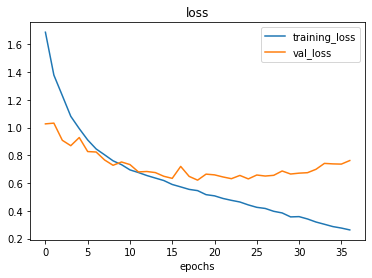

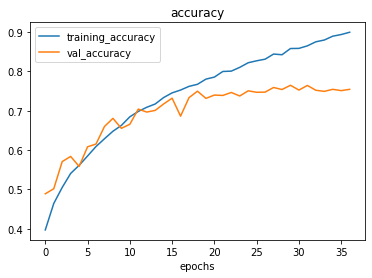

In [70]:
plot_loss_curves(history)

**As seen from the loss curves, our model overfits the data a little bit, but lets keep it the way it is.**

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

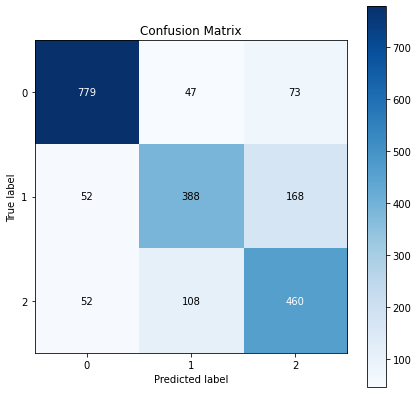

In [80]:
predictions = model.predict(X_test)
# print(predictions.shape)
# Out: (2127, 3)

# print(predictions[0])
# Out: [9.9655080e-01 2.4436100e-04 3.2048512e-03]
# Here we have predicted probability for each class, but we need the class with maximum probability.

# print("Getting the index of class with maximum probability.")
predictions = np.argmax(predictions, axis=1) # Getting the index of maximum probability class.

# print(predictions)
# Out: [0 2 1 ... 2 0 1]
# Now we have the 1-D list of the classes having maximum probability in their respective lists

plot_confusion_matrix(np.argmax(y_test, axis=1), predictions, figsize=(7, 7))

**Hmm, our model predicted:**

* **`779` correct images for class `1`**
* **`388` correct images for class `2`**
* **`460` correst images for class `3`**

**Now let's take a sample image and try to plot and predict its class**

In [83]:
def load_and_prepare_image(filename, image_shape=48):
    """
        Args:
            filename (str) : image path for reading and processing the image
            image_shape (str) : image shape to resize the image accordingly
        Returns:
            An image tensor of size (image_shape, image_shape)
    """
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, 1)
    img = tf.image.resize(img, size=[image_shape, image_shape])
    img = img/255.
    return img


# The classes list, these are the available classes that our model will try to predict
classes = ["happy", "sad", "neutral"]


def predict_class(model, filename):
    """
        Args:
            model (tensorflow model object) : a model which will predict the class of the image
            filename (str) : image path for predicting the class
    """
    img = load_and_prepare_image(filename)
    plt.imshow(img)
    predict_x = model.predict(tf.expand_dims(img, axis=0))
    class_name = classes[tf.argmax(predict_x[0])]
    print(class_name)


happy


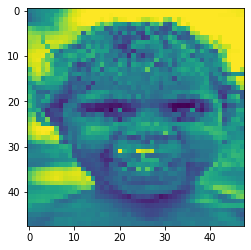

In [85]:
predict_class(model=model, filename="images_f/ha.jpg")


neutral


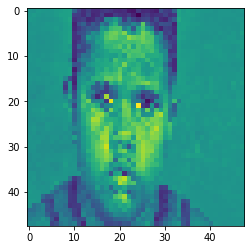

In [86]:
predict_class(model=model, filename="images_f/ss.jpg")

sad


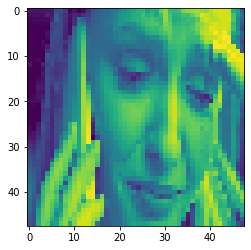

In [87]:
predict_class(model=model, filename="images_f/sa.jpg")

**With this the main part (Getting a trained model from the data) is completed.**

**In project_em_predict.py, we've used OpenCV to complete the project and predict the emoji out of the predicted class.**

> **Note: Some alternate models were also created containing more number of classes, slightly different architectures, etc... but they have low accuracy. Some of them are provided on the alternate_models directory on the github.**